# Classification of Cataract Ocular Disease using Bayesian Convolutional Neural Network

Ocular disease refers to any type of disease or infection which may affect the
health of vision of the eyes. Common ocular diseases are cateracts, glaucoma,
and diabetic eye disease, among others. Early detection of ocular disease is
crucial to prevent possible blindness caused by these diseases, and allows for
effective treatment.

It is quite difficult for doctors to detect or identify ocular diseases early
using only fundus images. It is a time-consuming, error-prone and complex
process. Thus, an automated detection system utilizing computational and machine learning tools (such as deep learning and Deep Neural Networks) would prove tremendously helpful and aid in improving the process of ocular
disease detection with possibly greater accuracy.

In this notebook, we will apply the use of Bayesian Convolutional Neural Networks to classify whether a patient suffers from an ocular disease or not.

## Bayesian Convolutional Neural Network

### Importing Libraries 

In [84]:
import numpy as np
import pandas as pd
import os
import glob
import random
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2
from random import shuffle 
from IPython.display import SVG
import pickle
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os
import shutil
import time
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (12, 6)
import splitfolders
from IPython import display

### Importing and Viewing Ocular Disease Intelligent Recognition (ODIR) Dataset

The Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5000 patients with the following features:
- age
- color fundus photographs from left and right eye
- doctors’ diagnostic keywords from doctors. 

This dataset represents the ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss, and Kowa, resulting in varied image resolutions. Annotations were labeled by trained human readers with quality control management. 
They classify patients into eight classes of ocular disease:
- Normal(N) which indicates the person does not appear to have any eye disease
- diabetes (D)
- glaucoma (G)
- cataract (C)
- AMD (A)
- hypertension (H)
- myopia (M)
- other diseases/abnormalities (O).

In [2]:
df = pd.read_csv("archive/full_df.csv")

In [3]:
# Viewing the first 5 observations
df.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

### Exploratory Data Analysis 

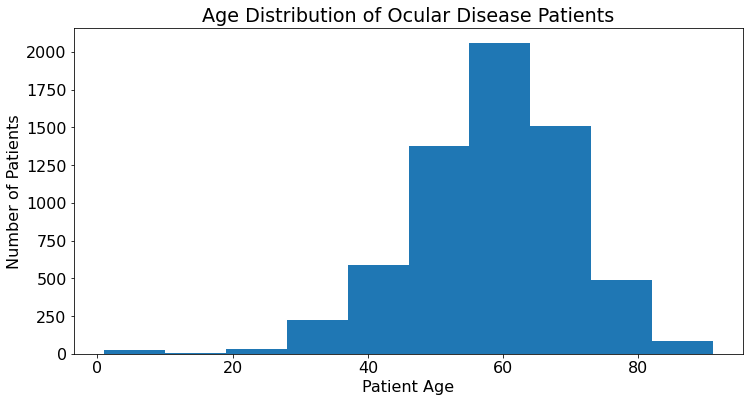

In [4]:
plt.hist(df['Patient Age']);
plt.title("Age Distribution of Ocular Disease Patients")
plt.xlabel("Patient Age")
plt.ylabel("Number of Patients")
plt.show()

**Interpretation:** Most patients represented in the ODIR dataset are in between the age of 55-75

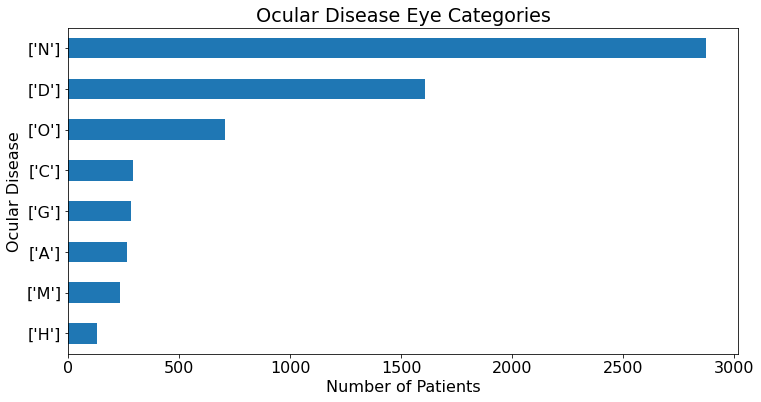

In [5]:
df['labels'].value_counts().sort_values().plot(kind = 'barh');
plt.title("Ocular Disease Eye Categories")
plt.ylabel("Ocular Disease")
plt.xlabel("Number of Patients")
plt.show()

**Interpretation:** The most represented Ocular Disease is ['D'] (Diabetes) followed by ['O'] (Other diseases/abnormalities) and ['C'] (Cataract).

### Extracting Cataract & Normal Class Information from the ODIR Dataset
- This will enable us to focus on predicting the Normal & Cataract class in the modelling phase

The reasons for choosing the cataract class even though diabetes clearly has more patient records are as follows:
- Cataract is currently the leading cause of vision impairment and blindness, alongside uncorrected refractive errors.
- The diabetes images are almost indistinguishable from the normal class images, which would lead to the model being harder to train or make accurate predictions. Detecting cataract is thus a much easier task because these images vary a lot from the normal fundus.

In [6]:
# Function to check if texts have the word cataract
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [7]:
# Creating columns with cataract labels
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [8]:
# Extracting cataract image names from the left eye diagnostic
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:5]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg'], dtype=object)

In [9]:
# Extracting cataract image names from the right eye diagnostic
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:5]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg'], dtype=object)

In [10]:
# Number of images for left and right eye cataract 
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [14]:
# Creating a Dataframe of Left and Right eye Cataract Images
left_catarct_dataframe = df.loc[(df.C ==1) & (df.left_cataract == 1)]
right_cataract_dataframe = df.loc[(df.C ==1) & (df.right_cataract == 1)]
cataract_lr_df = pd.concat([left_catarct_dataframe, right_cataract_dataframe])

In [20]:
# Randomly extracting normal eye images for left and right eye diagnostic
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

In [21]:
# Combining left and right eye image names for cataract and normal eyes
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [22]:
# Sample of Cataract Image filenames
cataract[:5]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg'], dtype=object)

In [23]:
# Sample of Normal Image filenames
normal[:5]

array(['3332_left.jpg', '4059_left.jpg', '69_left.jpg', '2415_left.jpg',
       '4176_left.jpg'], dtype=object)

In [24]:
print("Number of normal eye image names: {}".format(len(normal)))
print("Number of cataract eye image names: {}".format(len(cataract)))

Number of normal eye image names: 500
Number of cataract eye image names: 594


### Cataract Dataset Exploratory Analysis 

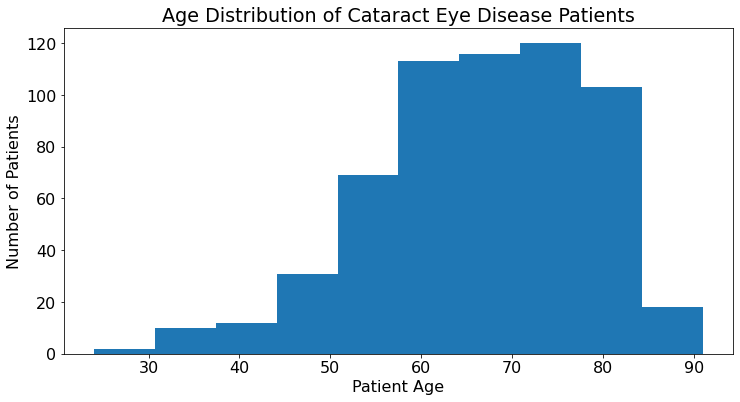

In [25]:
plt.hist(cataract_lr_df['Patient Age']);
plt.title("Age Distribution of Cataract Eye Disease Patients")
plt.xlabel("Patient Age")
plt.ylabel("Number of Patients")
plt.show()

**Interpretation:** Most Cataract patients in the ODIR dataset are aged between 60-80 years. 

In [27]:
# Statistical Summary of Cataract Patient Age
cataract_lr_df['Patient Age'].describe()

count    594.000000
mean      66.742424
std       11.719285
min       24.000000
25%       60.000000
50%       68.000000
75%       75.000000
max       91.000000
Name: Patient Age, dtype: float64

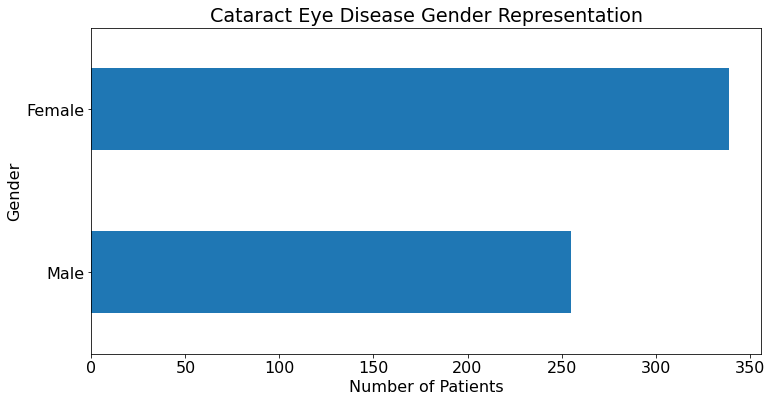

In [26]:
cataract_lr_df['Patient Sex'].value_counts().sort_values().plot(kind = 'barh');
plt.title("Cataract Eye Disease Gender Representation")
plt.ylabel("Gender")
plt.xlabel("Number of Patients")
plt.show()

**Interpretation:** As shown above, most patients with Cataract in the ODIR dataset are females 

### Copying Normal and Cataract Images Files to New Destination for Modelling

In [59]:
# Normal Images
source = 'archive/preprocessed_images/'
destination = 'archive/ocular_disease_data/Normal/'
  
for img in tqdm(normal):
    shutil.copyfile(source + img, destination + img)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1740.51it/s]


In [65]:
# Cataract Images
source = 'archive/preprocessed_images/'
destination = 'archive/ocular_disease_data/Cataract/'
  
for img in tqdm(cataract):
    try:
        shutil.copyfile(source + img, destination + img)
    except IOError as e:
        print(e)

 80%|██████████████████████████████████████████████████████████████▋               | 477/594 [00:00<00:00, 2236.28it/s]

[Errno 2] No such file or directory: 'archive/preprocessed_images/2102_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/2231_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/2244_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/2251_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/1456_right.jpg'


100%|██████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 2309.93it/s]

[Errno 2] No such file or directory: 'archive/preprocessed_images/2229_right.jpg'


### Creating a Train and Test Dataset
- 90% Train and 10% Test
- Normal Class: 481
- Cataract Class: 301
- Total Number of Images for Normal and Cataract Class: 782

In [67]:
input_dir = os.path.join('archive/ocular_disease_data/')
output_dir = os.path.join('archive/ocular_disease_data_splitted/')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.9, .1), group_prefix=None) 

Copying files: 782 files [00:02, 322.41 files/s]


In [30]:
train_dir = os.path.join('archive/ocular_disease_data_splitted/train/')
test_dir = os.path.join('archive/ocular_disease_data_splitted/val/')

### Data Preprocessing and Transformation

**Process**
- `Rescale images to 1/255:` Rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our model to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. 
- `Resizing all images to (75,75)`
- `Batch size:`No. of images to be yielded from the generator per batch.
- `Class mode - Categeorical:` This for 2D outputs (Normal and Cataract)

In [31]:
def image_generator(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 44,
                                  class_mode = 'categorical',
                                  subset='training')
 
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 4,
                                 class_mode = 'categorical')    
    
    return train_generator, test_generator

In [32]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 702 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


## Modelling

For this notebook we will be comparing the Standard CNN model to the Bayesian CNN model. Below you can see the difference in a standard CNN and a Bayesian CNN. The top plot has single point-estimates as weights, and the bottom is a Bayesian CNN with probability distributions over weights.

<img src="./cnn vs BCNN.png" style="width:600px;height:600px;">

## Standard Convolutional Neural Network (CNN)

Convolutional Neural Networks are mainly utilized to handle image data,
and are thus used in computer vision problems such as image classification
and segmentation. This is due to its ability to easily handle sets of non-linear
data points.

The main advantage of CNN is that it is capable of performing automatic feature extraction (able to detect the most important/significant features without any human supervision).

CNN is also computationally efficient. It uses special convolution and pooling operations and performs parameter sharing. This enables CNN models to run on any device.

### Neural Network (NN) Architecture
- The NN Architecture below is used throughout the modelling phase/steps
![alt text](nn_architecture.png "Neural Network (NN) Architecture")

### CNN Model Architecture 
- `Softmax Activation Function in Output Layer:` The softmax function is used as the activation function in the output layer of neural network. For binary classification (Normal and Cataract), it should give the same results, because softmax is a generalization of sigmoid for a larger number of classes. Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector.


- `Relu Activation Function in Hidden Layers:`We use ReLU in hidden layer to avoid vanishing gradient problem and for better computation performance. ReLU helps to prevent the exponential growth in the computation required to operate the neural network. 

In [33]:
model = Sequential([
    Conv2D(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(units=2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 8)         6152      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

### Compiling CNN Model

- `Loss - categorical cross-entropy:`categorical cross-entropy is for multi-class classification, but both work for binary classification, for categorical cross-entropy you need to change data to categorical(one-hot encoding). Thus the use of one-hot encoding 
- `Optimzer - Adam:` Adam is the best optimizers as shown in literature. If one wants to train the neural network in less time and more efficiently than Adam is the best optimizer to select. 
- `Metric - Accurarcy:`  Since this is a classification problem and the data is near evenly balance the Accurarcy metric is used. Accuracy = Number of correct predictions over the Total number of predictions.

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### CNN Model Training 
- `Model Checkpoint:` To serialize the neural network to disk each time there is an improvement during training. We define an “improvement” to be either a decrease in loss or an increase in accuracy. To get a sense of generalizability, validation metric - accuracy is used. Validation metrics provides a better sense of generalizability

In [38]:
checkpoint_model = ModelCheckpoint("cnn_model_1.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

In [40]:
start = time.time()
history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=100,
      validation_data = test_generator,
      verbose=1,
      callbacks = [checkpoint_model])
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.6187
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to cnn_model_1.h5
10/10 [==============================] - 4s 331ms/step - loss: 0.6680 - accuracy: 0.6187 - val_loss: 0.6634 - val_accuracy: 0.6125
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.6164
Epoch 2: val_accuracy did not improve from 0.61250
10/10 [==============================] - 2s 210ms/step - loss: 0.6474 - accuracy: 0.6164 - val_loss: 0.6435 - val_accuracy: 0.6125
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6164
Epoch 3: val_accuracy did not improve from 0.61250
10/10 [==============================] - 2s 188ms/step - loss: 0.6502 - accuracy: 0.6164 - val_loss: 0.6291 - val_accuracy: 0.6125
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6164
Epoch 4: val_accuracy improved from 0.612

10/10 [==============================] - 2s 197ms/step - loss: 0.2356 - accuracy: 0.9110 - val_loss: 0.2387 - val_accuracy: 0.9375
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9247
Epoch 30: val_accuracy did not improve from 0.93750
10/10 [==============================] - 2s 210ms/step - loss: 0.1988 - accuracy: 0.9247 - val_loss: 0.2430 - val_accuracy: 0.9250
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9155
Epoch 31: val_accuracy did not improve from 0.93750
10/10 [==============================] - 2s 192ms/step - loss: 0.2026 - accuracy: 0.9155 - val_loss: 0.2531 - val_accuracy: 0.9000
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9247
Epoch 32: val_accuracy did not improve from 0.93750
10/10 [==============================] - 2s 187ms/step - loss: 0.2022 - accuracy: 0.9247 - val_loss: 0.2531 - val_accuracy: 0.8750
Epoch 33/100
10/10 [============

Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9886
Epoch 59: val_accuracy did not improve from 0.95000
10/10 [==============================] - 3s 256ms/step - loss: 0.0444 - accuracy: 0.9886 - val_loss: 0.3294 - val_accuracy: 0.9250
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9932
Epoch 60: val_accuracy did not improve from 0.95000
10/10 [==============================] - 3s 250ms/step - loss: 0.0300 - accuracy: 0.9932 - val_loss: 0.3597 - val_accuracy: 0.9125
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9932
Epoch 61: val_accuracy did not improve from 0.95000
10/10 [==============================] - 3s 252ms/step - loss: 0.0265 - accuracy: 0.9932 - val_loss: 0.4231 - val_accuracy: 0.9125
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9977
Epoch 62: val_accuracy did not improve from 0.95000
10/10 [========

10/10 [==============================] - 2s 199ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6489 - val_accuracy: 0.9125
Epoch 89/100
10/10 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 89: val_accuracy did not improve from 0.95000
10/10 [==============================] - 2s 200ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6507 - val_accuracy: 0.9125
Epoch 90/100
10/10 [==============================] - ETA: 0s - loss: 8.7676e-04 - accuracy: 1.0000
Epoch 90: val_accuracy did not improve from 0.95000
10/10 [==============================] - 2s 201ms/step - loss: 8.7676e-04 - accuracy: 1.0000 - val_loss: 0.6486 - val_accuracy: 0.9250
Epoch 91/100
10/10 [==============================] - ETA: 0s - loss: 8.9017e-04 - accuracy: 1.0000
Epoch 91: val_accuracy did not improve from 0.95000
10/10 [==============================] - 2s 201ms/step - loss: 8.9017e-04 - accuracy: 1.0000 - val_loss: 0.6813 - val_accuracy: 0.9250
Epoch 92/100
10/

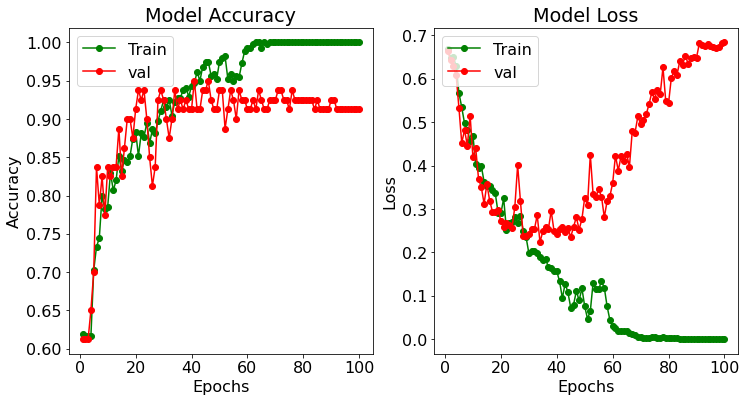

In [41]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Saving Model

In [100]:
model.save('ocular_disease_CNN_model.h5')

### Ocular Disease Prediction Function

In [42]:
def import_and_predict(image_data, label):
    
    #read image
    img = cv2.imread(image_data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    # resize and reshape the image
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    img_reshape = img_resize[np.newaxis,...]
    
    #predict the image
    prediction = model.predict(img_reshape)
    print(prediction)
    
    label_prediction = label[np.argmax(prediction)]
    
    return label_prediction

In [43]:
label = os.listdir(test_dir)

### CNN Model Predictions

In [44]:
image1_dir = os.path.join(test_dir+'Cataract/112_right.jpg')
image2_dir = os.path.join(test_dir+'Normal/394_right.jpg')

In [45]:
# suppressing scientific notation when printing float values
pd.options.display.float_format = '{:.2f}'.format

[[0.99763703 0.00236291]]


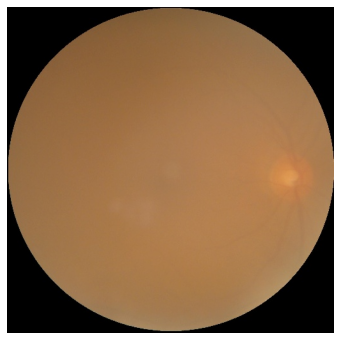

In [46]:
prediction1 = import_and_predict(image1_dir, label)

In [47]:
prediction1

'Cataract'

In [50]:
pd.options.display.float_format = '{:.2f}'.format

[[2.4583493e-08 1.0000000e+00]]


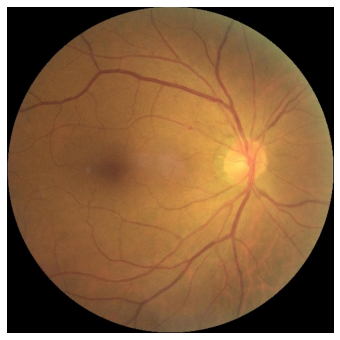

In [51]:
prediction2 = import_and_predict(image2_dir, label)

In [52]:
prediction2

'Normal'

## Bayesian Convolutional Neural Network (BCNN)
The main problem with the standard CNN lies in the fact that it requires a large amount
of data to train on to reduce the chances of overfitting. Since our data is
quite small, we apply Bayesian statistics to the neural network. Applying
this means that we are utilizing statistical methods to cover a probability
distribution attached to the network with the network parameters. It thus
reduces the chances of overfitting on smaller datasets.

CNNs being prone to overfitting on small datasets means that the model
tends to fit well to the training data, but are not predictive for new data.
This often makes it incapable of correctly assessing the uncertainty in the
training data and model predictions, thus leading to overly confident decisions about what the correct classification or prediction may be. The use of
Bayesian statistics in the model allows one to estimate the uncertainty in the
model predictions, by offering uncertainty estimates through its parameters
in the form of probability distributions.


### BCNN Uncertainties
The following uncertainties are taken into account by the BCNN:
- `Epistemic uncertainty` is the uncertainty that arises from the model itself. With the epistemic uncertainty, the BCNN model basically knows what it doesn’t know
- `Aleatoric uncertainty`, which is the uncertainty that arises from the quality of the data.

In [53]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

### BCNN Model Architecture

In [54]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [55]:
model_bayes.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 60, 60, 8)        12304     
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                      

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

### Compiling BCNN Model

In [57]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.05),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

### BCNN Model Training

In [58]:
checkpoint_bcnn_model = ModelCheckpoint("bcnn_model_1.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

In [61]:
start = time.time()
history_bayes = model_bayes.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_bcnn_model],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 9.4452 - accuracy: 0.5214
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to bcnn_model_1.h5
16/16 [==============================] - 3s 170ms/step - loss: 9.4452 - accuracy: 0.5214 - val_loss: 9.3523 - val_accuracy: 0.4875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 9.2855 - accuracy: 0.5185
Epoch 2: val_accuracy improved from 0.48750 to 0.51250, saving model to bcnn_model_1.h5
16/16 [==============================] - 3s 171ms/step - loss: 9.2855 - accuracy: 0.5185 - val_loss: 9.1840 - val_accuracy: 0.5125
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 9.1146 - accuracy: 0.5413
Epoch 3: val_accuracy improved from 0.51250 to 0.55000, saving model to bcnn_model_1.h5
16/16 [==============================] - 3s 173ms/step - loss: 9.1146 - accuracy: 0.5413 - val_loss: 9.0209 - val_accuracy: 0.5500
Epoch 4/100
16/16 [==============================] - ETA: 0s 

Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 6.8365 - accuracy: 0.5470
Epoch 30: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 186ms/step - loss: 6.8365 - accuracy: 0.5470 - val_loss: 6.7997 - val_accuracy: 0.5000
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 6.7593 - accuracy: 0.5370
Epoch 31: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 185ms/step - loss: 6.7593 - accuracy: 0.5370 - val_loss: 6.7170 - val_accuracy: 0.4875
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 6.6876 - accuracy: 0.5470
Epoch 32: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 187ms/step - loss: 6.6876 - accuracy: 0.5470 - val_loss: 6.6524 - val_accuracy: 0.6250
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 6.6154 - accuracy: 0.5484
Epoch 33: val_accuracy did not improve from 0.62500
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 4.7025 - accuracy: 0.5299
Epoch 88: val_accuracy did not improve from 0.67500
16/16 [==============================] - 3s 186ms/step - loss: 4.7025 - accuracy: 0.5299 - val_loss: 4.6784 - val_accuracy: 0.4250
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 4.6629 - accuracy: 0.5071
Epoch 89: val_accuracy did not improve from 0.67500
16/16 [==============================] - 3s 186ms/step - loss: 4.6629 - accuracy: 0.5071 - val_loss: 4.6325 - val_accuracy: 0.5625
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 4.6260 - accuracy: 0.5598
Epoch 90: val_accuracy did not improve from 0.67500
16/16 [==============================] - 3s 189ms/step - loss: 4.6260 - accuracy: 0.5598 - val_loss: 4.5968 - val_accuracy: 0.5250
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 4.5817 - accuracy: 0.5385
Epoch 91: val_accuracy did not improve from 0.67500
16/16 [=====================

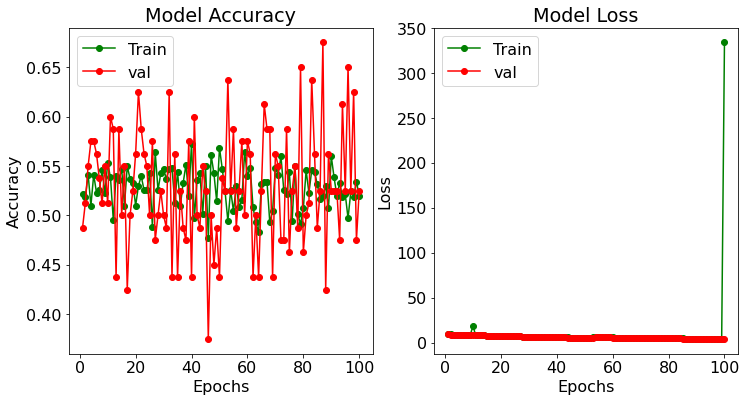

In [62]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes.history["accuracy"],"go-")
plt.plot(epochs,history_bayes.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes.history["loss"],"go-")
plt.plot(epochs,history_bayes.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### BCNN Model Saving

In [101]:
model_bayes.save('ocular_disease_BCNN_model.h5')

### BCNN Ocular Disease Prediction Function

#### Prediction Interpretation in bayesian 

Bayesian methods use probabilities as a tool to quantify uncertainty, thus the term `Probabilistic` can be used as a neutral term for `Bayesian`. Probabilistic models are built by properly combining probability distributions, thus the predictions can be interpretated as follows:

**Interpretation of Bayesian Prediction:**

 `Interpretation of the Bayesian 95% credible interval:` there is a 95% probability that the true (unknown) estimate would lie within the interval, given the evidence provided by the observed data.
 
[Understanding and interpreting confidence and credible intervals around effect estimates](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6630113/)

#### Bayesian Neural Network Prediction Interpretation:

Since we have built a probabilistic model (Bayesian Convolutional Neural Network), then we’re not going to get the same probability value when predicting an image. Because of that, we’re going to assign the model to predict our image several times instead of just once. The model will be assigned to predict a single image 300 times instead of just one time.

`Based on that 300 predictions, a 97.5% prediction interval (credible interval) for probabilities will be created`

`The 97.5% probability is our degree of certainty that an image classification probability lies within a certain range`

In [63]:
def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 2))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(2)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(2)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(2), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(2), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

In [115]:
def import_and_predict_bayes_v(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 2))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(2)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(2)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(2), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(2), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()
    
    average_estimate = np.array([np.mean(predicted_probabilities[:, i]) for i in range(2)])*100
    prediction_label = label[np.argmax(average_estimate)]
    highest_prediction = average_estimate.max()
    print("Most likely Ocular Condition:", prediction_label, "-", round(highest_prediction,2), "%")
    cert_2p5 = pct_2p5*100
    cert_97p5 = pct_97p5*100
    for i in range(2):
        print(label[i], ": Average estimate = ", round(average_estimate[i],2),
             ": 97.5% ", round(cert_2p5[i], 2), "-", round(cert_97p5[i], 2))

In [106]:
image1_dir = os.path.join(test_dir+'Cataract/112_right.jpg')
image2_dir = os.path.join(test_dir+'Cataract/2140_left.jpg')
image3_dir = os.path.join(test_dir+'Cataract/2155_right.jpg')
image4_dir = os.path.join(test_dir+'Cataract/2231_right.jpg')
image5_dir = os.path.join(test_dir+'Cataract/824_left.jpg')
image6_dir = os.path.join(test_dir+'Normal/42_left.jpg')
image7_dir = os.path.join(test_dir+'Normal/500_right.jpg')
image8_dir = os.path.join(test_dir+'Normal/3207_left.jpg')
image9_dir = os.path.join(test_dir+'Normal/2849_right.jpg')
image10_dir = os.path.join(test_dir+'Normal/3262_left.jpg')

### Predictions with Credible Intervals and Visualisations

### Cataract Class

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


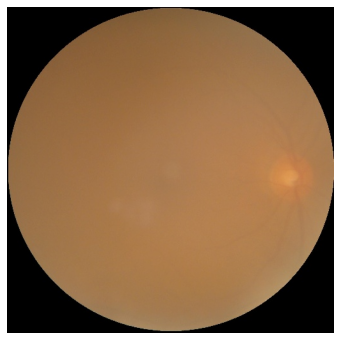

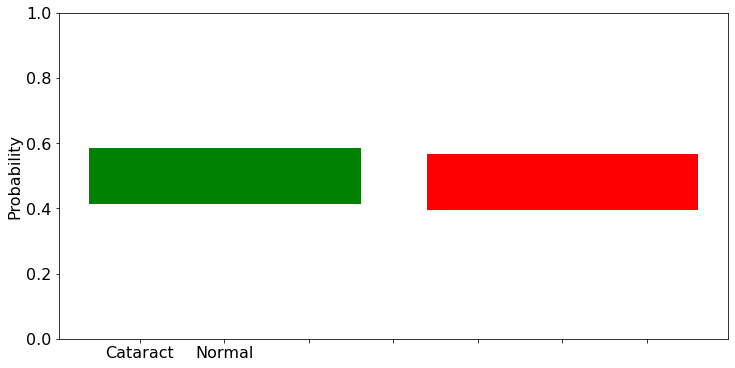

Most likely Ocular Condition: Cataract - 51.16 %
Cataract : Average estimate =  51.16 : 97.5%  43.35 - 58.6
Normal : Average estimate =  48.84 : 97.5%  41.4 - 56.65


In [116]:
import_and_predict_bayes_v(image1_dir, label.index('Cataract'))

**Interpretation:**
- The 97.5% probability is our degree of certainty that an image classification probability lies within a certain range
- `Cataract:`There is a 97.5% probability (certainity) that the Catarct Classification probability lie between 43.35% - 58.6% given the observed data (Cataract Image)
- `Normal:`There is a 97.5% probability (certainty) that the Catarct Classification probability lie between 41.4% - 56.65% given the observed data (Normal Image)

when looking at the result from our Bayesian CNN model above, the aleatoric and epistemic uncertainty actually exist when predicting the Cataract image:

- The aleatoric uncertainty is shown as the model also assigns a midium probability value for the Normal class.
- The epistemic uncertainty is shown as the model itself is not certain how big of a probability value that it should assign in each of the Ocular Disease classes (Cataract and Normal).

`Same interpretation for the remaining image predictions`

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


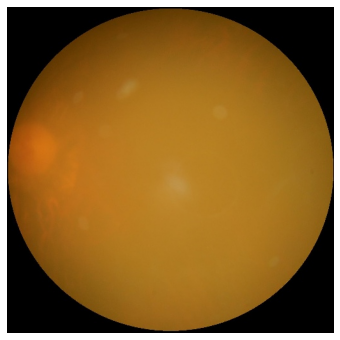

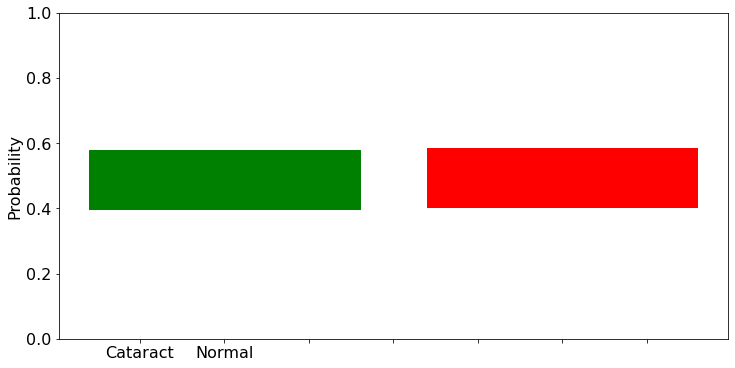

Most likely Ocular Condition: Cataract - 50.06 %
Cataract : Average estimate =  50.06 : 97.5%  41.61 - 57.82
Normal : Average estimate =  49.94 : 97.5%  42.18 - 58.39


In [117]:
import_and_predict_bayes_v(image2_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


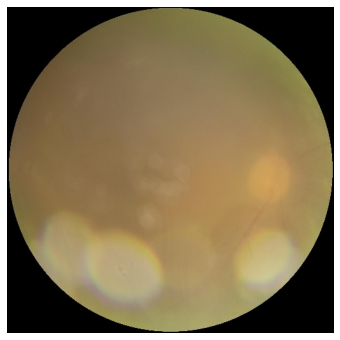

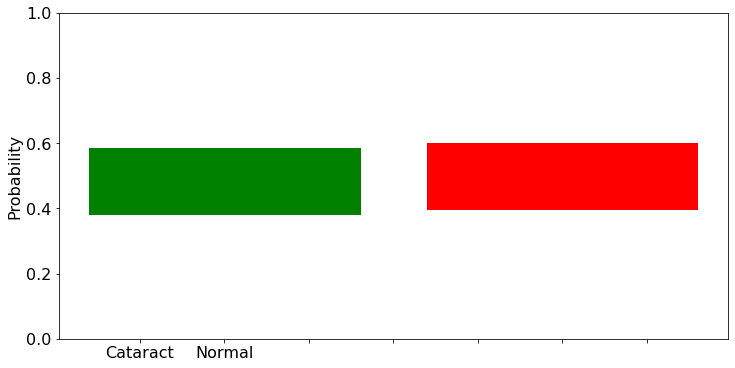

Most likely Ocular Condition: Cataract - 50.48 %
Cataract : Average estimate =  50.48 : 97.5%  39.86 - 58.46
Normal : Average estimate =  49.52 : 97.5%  41.54 - 60.14


In [118]:
import_and_predict_bayes_v(image3_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


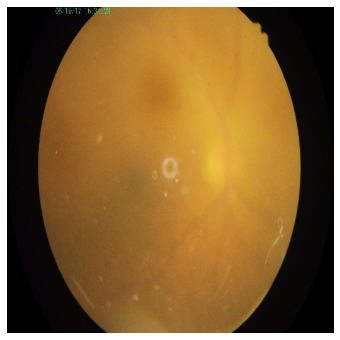

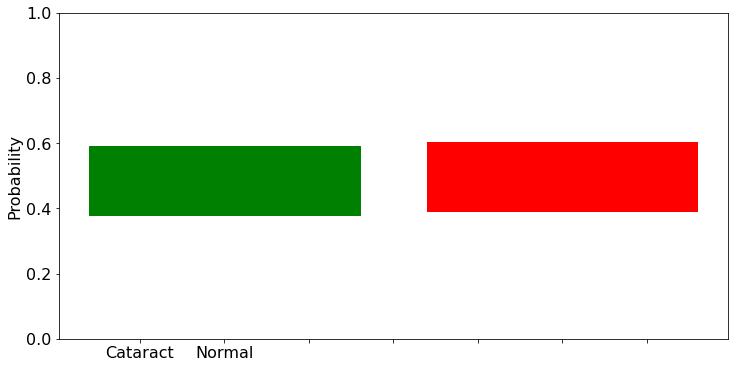

Most likely Ocular Condition: Normal - 50.06 %
Cataract : Average estimate =  49.94 : 97.5%  39.72 - 59.07
Normal : Average estimate =  50.06 : 97.5%  40.93 - 60.28


In [119]:
import_and_predict_bayes_v(image4_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


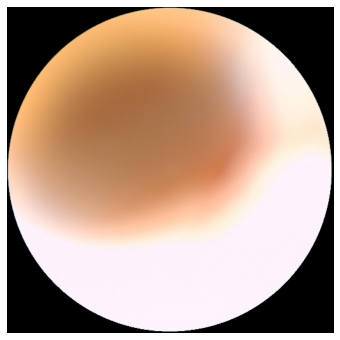

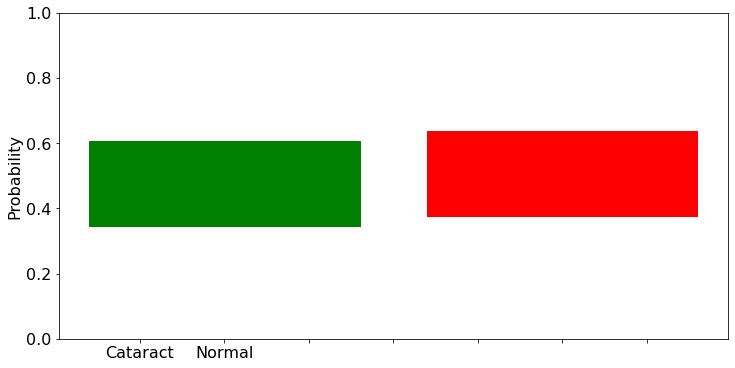

Most likely Ocular Condition: Normal - 50.69 %
Cataract : Average estimate =  49.31 : 97.5%  36.24 - 60.76
Normal : Average estimate =  50.69 : 97.5%  39.24 - 63.76


In [120]:
import_and_predict_bayes_v(image5_dir, label.index('Cataract'))

### Normal Class Predictions

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


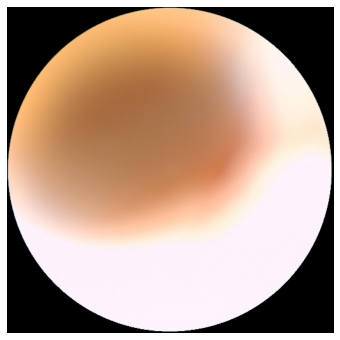

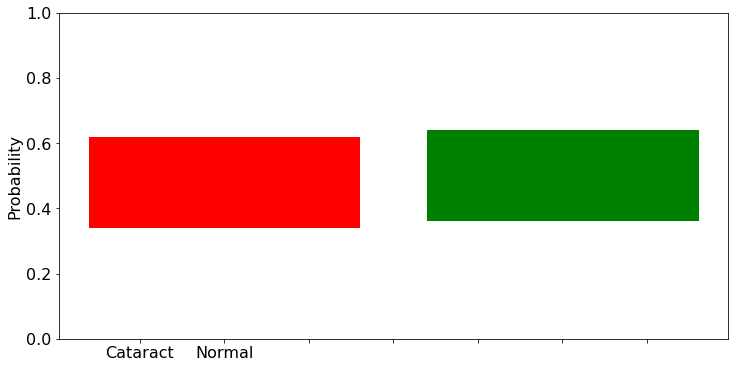

Most likely Ocular Condition: Normal - 50.85 %
Cataract : Average estimate =  49.15 : 97.5%  36.1 - 61.79
Normal : Average estimate =  50.85 : 97.5%  38.21 - 63.9


In [121]:
import_and_predict_bayes_v(image5_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


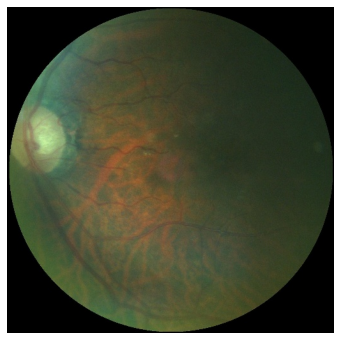

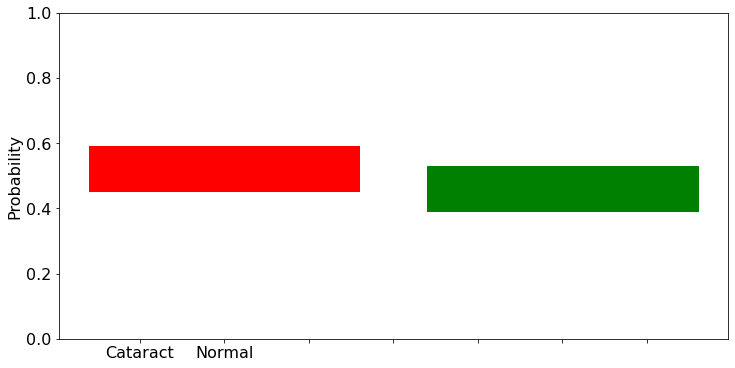

Most likely Ocular Condition: Cataract - 53.22 %
Cataract : Average estimate =  53.22 : 97.5%  47.1 - 59.0
Normal : Average estimate =  46.78 : 97.5%  41.0 - 52.9


In [122]:
import_and_predict_bayes_v(image6_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


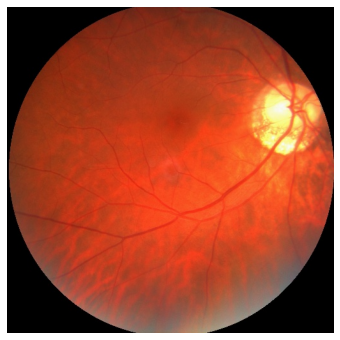

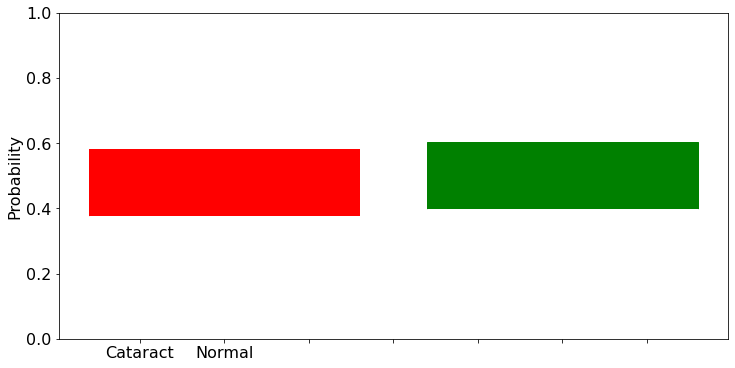

Most likely Ocular Condition: Normal - 50.61 %
Cataract : Average estimate =  49.39 : 97.5%  39.58 - 58.16
Normal : Average estimate =  50.61 : 97.5%  41.84 - 60.42


In [123]:
import_and_predict_bayes_v(image7_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


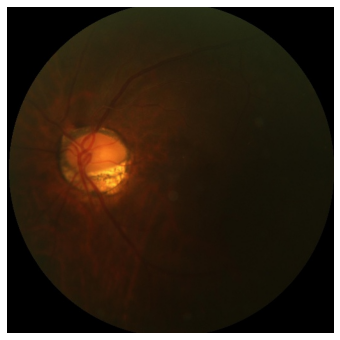

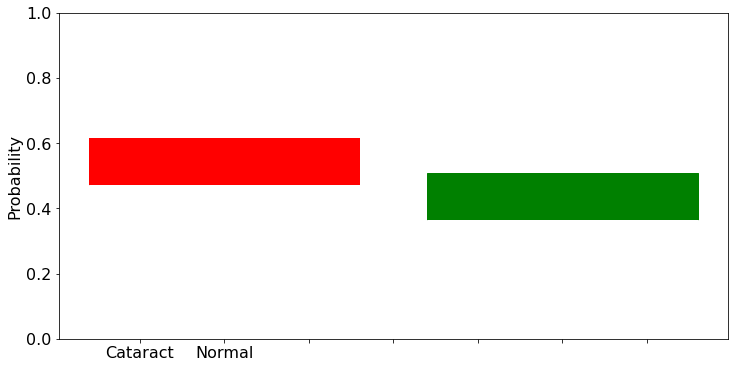

Most likely Ocular Condition: Cataract - 55.59 %
Cataract : Average estimate =  55.59 : 97.5%  49.22 - 61.47
Normal : Average estimate =  44.41 : 97.5%  38.53 - 50.78


In [124]:
import_and_predict_bayes_v(image8_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


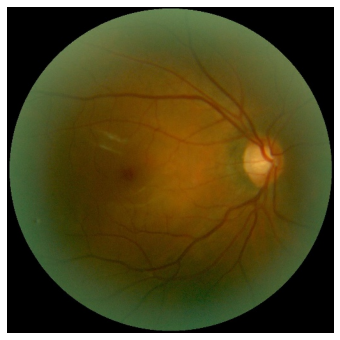

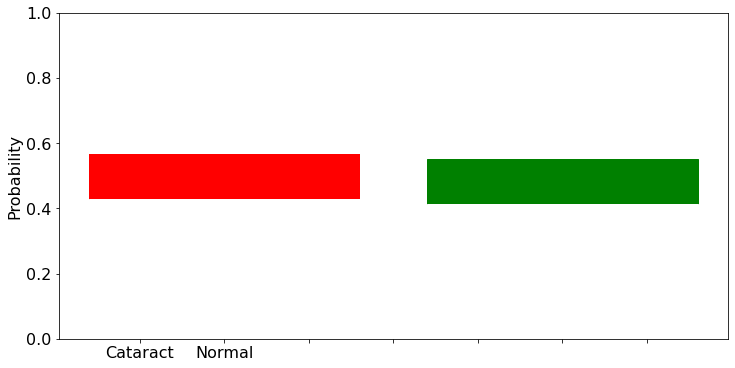

Most likely Ocular Condition: Cataract - 51.1 %
Cataract : Average estimate =  51.1 : 97.5%  44.74 - 56.76
Normal : Average estimate =  48.9 : 97.5%  43.24 - 55.26


In [125]:
import_and_predict_bayes_v(image9_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


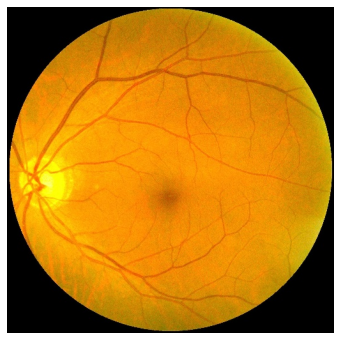

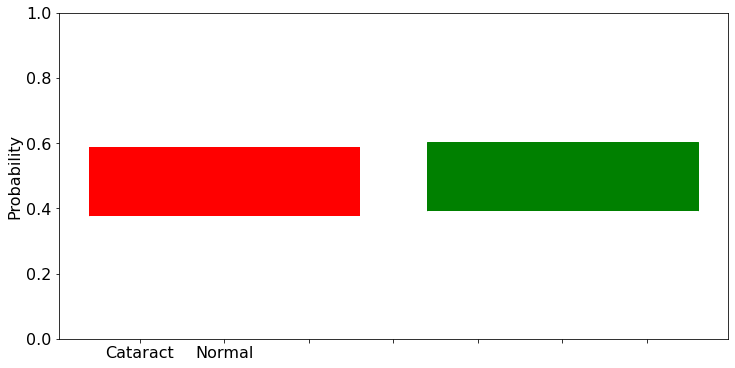

Most likely Ocular Condition: Normal - 50.45 %
Cataract : Average estimate =  49.55 : 97.5%  39.66 - 58.87
Normal : Average estimate =  50.45 : 97.5%  41.13 - 60.34


In [126]:
import_and_predict_bayes_v(image10_dir, label.index('Normal'))

### Random Image Prediction

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/4172194512.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


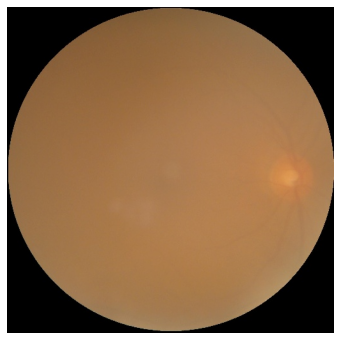

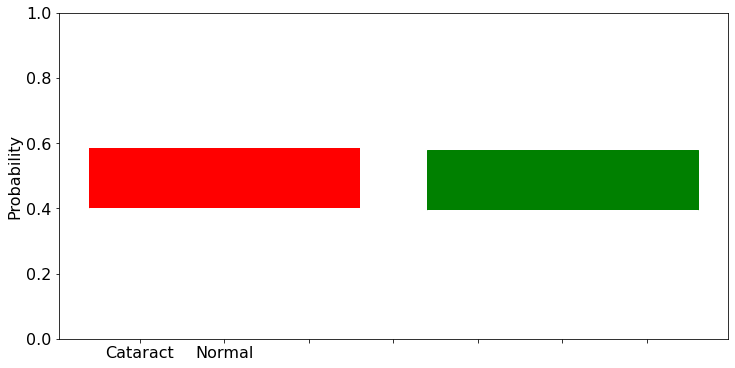

In [102]:
random_image_dir = 'archive/preprocessed_images/303_right.jpg'
import_and_predict_bayes(random_image_dir, label.index('Normal'))

## BCNN Model Experimentation

### Experiment: hyperparameters to tune
- **Tune number of neurons**
- **Tune Learning Rate**
- **Other Options to Tune:** activation function, optimizer, batch size, epochs, tune number of Neural Network Layers 

For the scope of this project, we will focus on tuning the number of neurons in each layer for the first set of experiments then we will tune the learning rate for the last set of experiments

In [167]:
def image_generator(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 44,
                                  class_mode = 'categorical',
                                  subset='training')
 
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 4,
                                 class_mode = 'categorical')    
    
    return train_generator, test_generator
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 702 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


## Experiment 0
- 64 Neurons

In [204]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes_experiment0 = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

In [205]:
model_bayes_experiment0.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_2  (None, 60, 60, 8)        12304     
 3 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 30, 30, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_81 (Conv2D)          (None, 28, 28, 64)        4672      
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 12, 12, 64)      

In [206]:
model_bayes_experiment0.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.05),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)
checkpoint_model_bayes_experiment0 = ModelCheckpoint("model_bayes_experiment0.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
start = time.time()
history_bayes_experiment0 = model_bayes_experiment0.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_model_bayes_experiment0],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 548.1710 - accuracy: 0.4729
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to model_bayes_experiment0.h5
16/16 [==============================] - 4s 205ms/step - loss: 548.1710 - accuracy: 0.4729 - val_loss: 22.3136 - val_accuracy: 0.6250
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 20.3346 - accuracy: 0.5783
Epoch 2: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 200ms/step - loss: 20.3346 - accuracy: 0.5783 - val_loss: 18.2501 - val_accuracy: 0.4625
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 16.8460 - accuracy: 0.5242
Epoch 3: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 180ms/step - loss: 16.8460 - accuracy: 0.5242 - val_loss: 15.3405 - val_accuracy: 0.5750
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 16.8857 - accuracy: 0.5214
Epoch 4: val_accu

16/16 [==============================] - 3s 181ms/step - loss: 11.2189 - accuracy: 0.4900 - val_loss: 11.1549 - val_accuracy: 0.5125
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 11.1122 - accuracy: 0.5114
Epoch 30: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 181ms/step - loss: 11.1122 - accuracy: 0.5114 - val_loss: 11.0618 - val_accuracy: 0.5875
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 11.0184 - accuracy: 0.4972
Epoch 31: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 180ms/step - loss: 11.0184 - accuracy: 0.4972 - val_loss: 10.9679 - val_accuracy: 0.5125
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 10.9203 - accuracy: 0.4957
Epoch 32: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 180ms/step - loss: 10.9203 - accuracy: 0.4957 - val_loss: 10.8732 - val_accuracy: 0.4875
Epoch 33/100
16/16 [=

16/16 [==============================] - 3s 182ms/step - loss: 9.3948 - accuracy: 0.5356 - val_loss: 9.3504 - val_accuracy: 0.4500
Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 9.3174 - accuracy: 0.5527
Epoch 59: val_accuracy did not improve from 0.70000
16/16 [==============================] - 3s 182ms/step - loss: 9.3174 - accuracy: 0.5527 - val_loss: 9.2751 - val_accuracy: 0.6250
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 9.2385 - accuracy: 0.5328
Epoch 60: val_accuracy did not improve from 0.70000
16/16 [==============================] - 3s 181ms/step - loss: 9.2385 - accuracy: 0.5328 - val_loss: 9.1966 - val_accuracy: 0.6375
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 9.1644 - accuracy: 0.5456
Epoch 61: val_accuracy did not improve from 0.70000
16/16 [==============================] - 3s 180ms/step - loss: 9.1644 - accuracy: 0.5456 - val_loss: 9.1207 - val_accuracy: 0.5375
Epoch 62/100
16/16 [============

Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 7.6455 - accuracy: 0.5399
Epoch 88: val_accuracy did not improve from 0.70000
16/16 [==============================] - 3s 187ms/step - loss: 7.6455 - accuracy: 0.5399 - val_loss: 7.6116 - val_accuracy: 0.4500
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 7.5747 - accuracy: 0.4843
Epoch 89: val_accuracy did not improve from 0.70000
16/16 [==============================] - 3s 186ms/step - loss: 7.5747 - accuracy: 0.4843 - val_loss: 7.5362 - val_accuracy: 0.4375
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 7.5048 - accuracy: 0.5570
Epoch 90: val_accuracy did not improve from 0.70000
16/16 [==============================] - 3s 185ms/step - loss: 7.5048 - accuracy: 0.5570 - val_loss: 7.4631 - val_accuracy: 0.5750
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 7.4392 - accuracy: 0.5413
Epoch 91: val_accuracy did not improve from 0.70000
16/16 [========

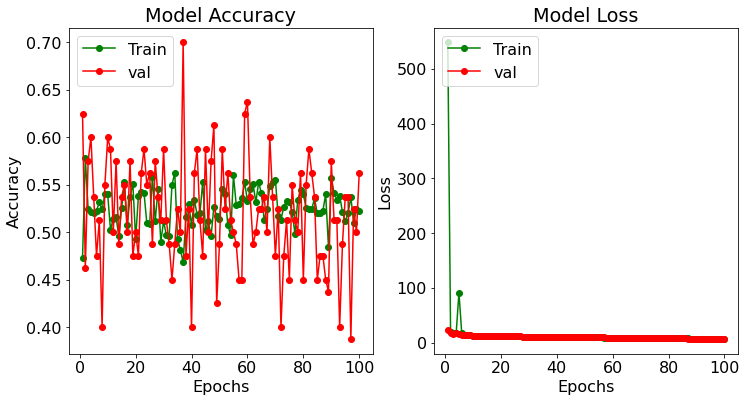

In [207]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_experiment0.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_experiment0.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_experiment0.history["loss"],"go-")
plt.plot(epochs,history_bayes_experiment0.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

## Experiment 1
- 128 Neurons

In [168]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes_experiment1 = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

In [169]:
model_bayes_experiment1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_1  (None, 60, 60, 8)        12304     
 8 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 28, 28, 128)       9344      
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 12, 12, 128)     

In [170]:
model_bayes_experiment1.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.05),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [171]:
checkpoint_model_bayes_experiment1 = ModelCheckpoint("model_bayes_experiment1.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

In [172]:
start = time.time()
history_bayes_experiment1 = model_bayes_experiment1.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_model_bayes_experiment1],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 7499.1060 - accuracy: 0.5342
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to model_bayes_experiment1.h5
16/16 [==============================] - 4s 206ms/step - loss: 7499.1060 - accuracy: 0.5342 - val_loss: 1685.6104 - val_accuracy: 0.6125
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 928.8393 - accuracy: 0.5427
Epoch 2: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 188ms/step - loss: 928.8393 - accuracy: 0.5427 - val_loss: 23.4892 - val_accuracy: 0.5375
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 49.0462 - accuracy: 0.5242
Epoch 3: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 195ms/step - loss: 49.0462 - accuracy: 0.5242 - val_loss: 23.0833 - val_accuracy: 0.5500
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 22.8679 - accuracy: 0.5556
Epoch 4: va

Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 19.8107 - accuracy: 0.4929
Epoch 30: val_accuracy did not improve from 0.61250
16/16 [==============================] - 4s 226ms/step - loss: 19.8107 - accuracy: 0.4929 - val_loss: 19.7589 - val_accuracy: 0.5125
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 19.7237 - accuracy: 0.5285
Epoch 31: val_accuracy did not improve from 0.61250
16/16 [==============================] - 4s 236ms/step - loss: 19.7237 - accuracy: 0.5285 - val_loss: 19.6788 - val_accuracy: 0.5000
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 19.6395 - accuracy: 0.5385
Epoch 32: val_accuracy did not improve from 0.61250
16/16 [==============================] - 4s 212ms/step - loss: 19.6395 - accuracy: 0.5385 - val_loss: 19.6050 - val_accuracy: 0.5625
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 19.5587 - accuracy: 0.5655
Epoch 33: val_accuracy did not improve from 0.61250
16/16

Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 17.7256 - accuracy: 0.5356
Epoch 59: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 215ms/step - loss: 17.7256 - accuracy: 0.5356 - val_loss: 17.6959 - val_accuracy: 0.4625
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 17.6700 - accuracy: 0.5470
Epoch 60: val_accuracy did not improve from 0.65000
16/16 [==============================] - 4s 238ms/step - loss: 17.6700 - accuracy: 0.5470 - val_loss: 17.6494 - val_accuracy: 0.5125
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 17.6091 - accuracy: 0.5199
Epoch 61: val_accuracy did not improve from 0.65000
16/16 [==============================] - 4s 228ms/step - loss: 17.6091 - accuracy: 0.5199 - val_loss: 17.5815 - val_accuracy: 0.6000
Epoch 62/100
16/16 [==============================] - ETA: 0s - loss: 17.5528 - accuracy: 0.5085
Epoch 62: val_accuracy did not improve from 0.65000
16/16

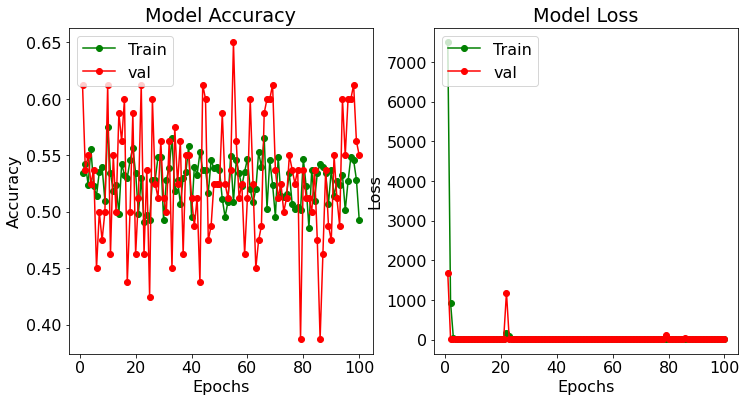

In [173]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_experiment1.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_experiment1.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_experiment1.history["loss"],"go-")
plt.plot(epochs,history_bayes_experiment1.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

## Experiment 2
- Neurons: 256

In [174]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes_experiment2 = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

In [175]:
model_bayes_experiment2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_1  (None, 60, 60, 8)        12304     
 9 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 28, 28, 256)       18688     
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 12, 12, 256)     

In [176]:
model_bayes_experiment2.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.05),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)
checkpoint_model_bayes_experiment2 = ModelCheckpoint("model_bayes_experiment2.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
start = time.time()
history_bayes_experiment2 = model_bayes_experiment2.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_model_bayes_experiment2],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 91362.1484 - accuracy: 0.5157
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to model_bayes_experiment2.h5
16/16 [==============================] - 5s 255ms/step - loss: 91362.1484 - accuracy: 0.5157 - val_loss: 14734.9004 - val_accuracy: 0.6125
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 26.0961 - accuracy: 0.4929
Epoch 2: val_accuracy did not improve from 0.61250
16/16 [==============================] - 4s 263ms/step - loss: 26.0961 - accuracy: 0.4929 - val_loss: 21.1981 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 11296.2510 - accuracy: 0.5271
Epoch 3: val_accuracy did not improve from 0.61250
16/16 [==============================] - 4s 267ms/step - loss: 11296.2510 - accuracy: 0.5271 - val_loss: 133.3307 - val_accuracy: 0.6000
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 41.5917 - accuracy: 0.5157
Epo

Epoch 58/100
16/16 [==============================] - ETA: 0s - loss: 19.4002 - accuracy: 0.5413
Epoch 58: val_accuracy did not improve from 0.72500
16/16 [==============================] - 4s 265ms/step - loss: 19.4002 - accuracy: 0.5413 - val_loss: 19.3905 - val_accuracy: 0.6000
Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 19.3824 - accuracy: 0.5085
Epoch 59: val_accuracy did not improve from 0.72500
16/16 [==============================] - 4s 259ms/step - loss: 19.3824 - accuracy: 0.5085 - val_loss: 19.3805 - val_accuracy: 0.5125
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 19.3785 - accuracy: 0.5085
Epoch 60: val_accuracy did not improve from 0.72500
16/16 [==============================] - 4s 256ms/step - loss: 19.3785 - accuracy: 0.5085 - val_loss: 19.3674 - val_accuracy: 0.6375
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 19.3703 - accuracy: 0.5470
Epoch 61: val_accuracy did not improve from 0.72500
16/16

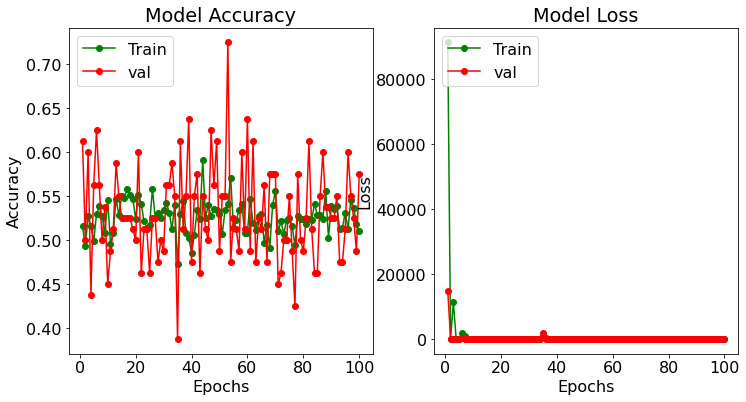

In [177]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_experiment2.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_experiment2.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_experiment2.history["loss"],"go-")
plt.plot(epochs,history_bayes_experiment2.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Experiment 3
- Learning rate: 0.001

In [178]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes_experiment3 = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

In [179]:
model_bayes_experiment3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_2  (None, 60, 60, 8)        12304     
 0 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 12, 12, 64)      

In [180]:
model_bayes_experiment3.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.001),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)
checkpoint_model_bayes_experiment3 = ModelCheckpoint("model_bayes_experiment3.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
start = time.time()
history_bayes_experiment3 = model_bayes_experiment3.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_model_bayes_experiment3],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 26.4896 - accuracy: 0.5413
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to model_bayes_experiment3.h5
16/16 [==============================] - 4s 179ms/step - loss: 26.4896 - accuracy: 0.5413 - val_loss: 26.3968 - val_accuracy: 0.4500
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 26.3783 - accuracy: 0.5313
Epoch 2: val_accuracy improved from 0.45000 to 0.62500, saving model to model_bayes_experiment3.h5
16/16 [==============================] - 3s 172ms/step - loss: 26.3783 - accuracy: 0.5313 - val_loss: 26.2200 - val_accuracy: 0.6250
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 26.1609 - accuracy: 0.5456
Epoch 3: val_accuracy improved from 0.62500 to 0.68750, saving model to model_bayes_experiment3.h5
16/16 [==============================] - 3s 171ms/step - loss: 26.1609 - accuracy: 0.5456 - val_loss: 26.0176 - val_accuracy: 0.6875
Epoch 4/100
16/16 [

Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 22.3246 - accuracy: 0.8120
Epoch 28: val_accuracy did not improve from 0.93750
16/16 [==============================] - 3s 206ms/step - loss: 22.3246 - accuracy: 0.8120 - val_loss: 22.2519 - val_accuracy: 0.8375
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 22.2465 - accuracy: 0.7977
Epoch 29: val_accuracy did not improve from 0.93750
16/16 [==============================] - 3s 190ms/step - loss: 22.2465 - accuracy: 0.7977 - val_loss: 22.0739 - val_accuracy: 0.8500
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 22.0900 - accuracy: 0.8162
Epoch 30: val_accuracy did not improve from 0.93750
16/16 [==============================] - 3s 217ms/step - loss: 22.0900 - accuracy: 0.8162 - val_loss: 21.9407 - val_accuracy: 0.8000
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 21.9180 - accuracy: 0.8205
Epoch 31: val_accuracy did not improve from 0.93750
16/16

16/16 [==============================] - ETA: 0s - loss: 14.4129 - accuracy: 0.9601
Epoch 86: val_accuracy did not improve from 0.93750
16/16 [==============================] - 3s 169ms/step - loss: 14.4129 - accuracy: 0.9601 - val_loss: 14.6144 - val_accuracy: 0.9000
Epoch 87/100
16/16 [==============================] - ETA: 0s - loss: 14.3325 - accuracy: 0.9501
Epoch 87: val_accuracy did not improve from 0.93750
16/16 [==============================] - 3s 170ms/step - loss: 14.3325 - accuracy: 0.9501 - val_loss: 14.4115 - val_accuracy: 0.8750
Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 14.2166 - accuracy: 0.9288
Epoch 88: val_accuracy did not improve from 0.93750
16/16 [==============================] - 3s 169ms/step - loss: 14.2166 - accuracy: 0.9288 - val_loss: 14.2858 - val_accuracy: 0.8500
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 14.1035 - accuracy: 0.9103
Epoch 89: val_accuracy did not improve from 0.93750
16/16 [===========

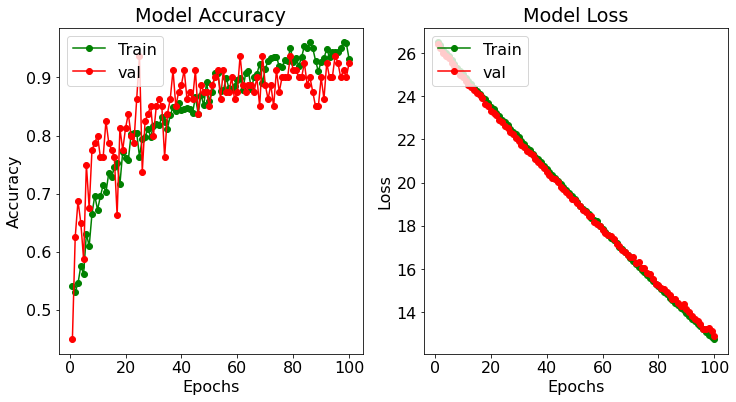

In [181]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_experiment3.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_experiment3.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_experiment3.history["loss"],"go-")
plt.plot(epochs,history_bayes_experiment3.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [182]:
model_bayes_experiment3.save('BCNN_model_lr_001.h5')

### Experiment 4
- Learning rate = 0.01

In [183]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes_experiment4 = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

In [184]:
model_bayes_experiment4.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_2  (None, 60, 60, 8)        12304     
 1 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 12, 12, 64)      

In [185]:
model_bayes_experiment4.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)
checkpoint_model_bayes_experiment4 = ModelCheckpoint("model_bayes_experiment4.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
start = time.time()
history_bayes_experiment4 = model_bayes_experiment4.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_model_bayes_experiment4],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 26.8769 - accuracy: 0.5199
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to model_bayes_experiment4.h5
16/16 [==============================] - 4s 193ms/step - loss: 26.8769 - accuracy: 0.5199 - val_loss: 25.2876 - val_accuracy: 0.4875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 24.6686 - accuracy: 0.5598
Epoch 2: val_accuracy improved from 0.48750 to 0.58750, saving model to model_bayes_experiment4.h5
16/16 [==============================] - 3s 197ms/step - loss: 24.6686 - accuracy: 0.5598 - val_loss: 23.9635 - val_accuracy: 0.5875
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 23.3384 - accuracy: 0.5313
Epoch 3: val_accuracy did not improve from 0.58750
16/16 [==============================] - 3s 174ms/step - loss: 23.3384 - accuracy: 0.5313 - val_loss: 22.6297 - val_accuracy: 0.5625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss

16/16 [==============================] - ETA: 0s - loss: 1.3811 - accuracy: 0.5470
Epoch 58: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 174ms/step - loss: 1.3811 - accuracy: 0.5470 - val_loss: 1.3819 - val_accuracy: 0.5375
Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 1.3654 - accuracy: 0.5484
Epoch 59: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 170ms/step - loss: 1.3654 - accuracy: 0.5484 - val_loss: 1.3791 - val_accuracy: 0.5125
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 1.3543 - accuracy: 0.5128
Epoch 60: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 193ms/step - loss: 1.3543 - accuracy: 0.5128 - val_loss: 1.3456 - val_accuracy: 0.5625
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 2.3147 - accuracy: 0.5228
Epoch 61: val_accuracy did not improve from 0.63750
16/16 [=====================

16/16 [==============================] - 3s 186ms/step - loss: 1.0832 - accuracy: 0.5342 - val_loss: 1.0809 - val_accuracy: 0.5250
Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 1.0776 - accuracy: 0.5299
Epoch 88: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 174ms/step - loss: 1.0776 - accuracy: 0.5299 - val_loss: 1.0651 - val_accuracy: 0.5375
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 1.0633 - accuracy: 0.5484
Epoch 89: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 174ms/step - loss: 1.0633 - accuracy: 0.5484 - val_loss: 1.0755 - val_accuracy: 0.5125
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 1.0598 - accuracy: 0.5256
Epoch 90: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 175ms/step - loss: 1.0598 - accuracy: 0.5256 - val_loss: 1.0655 - val_accuracy: 0.4250
Epoch 91/100
16/16 [============

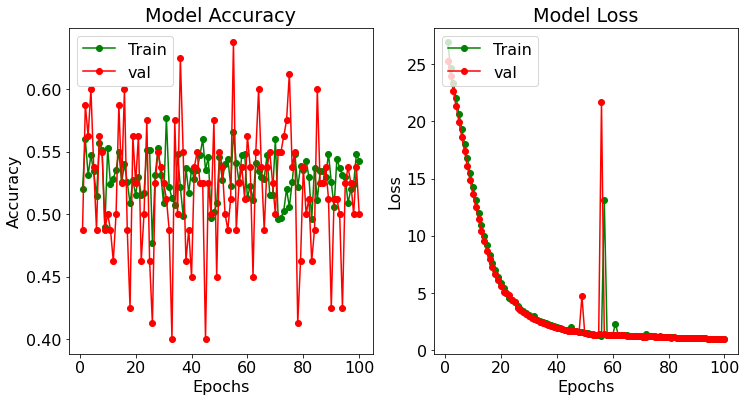

In [186]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_experiment4.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_experiment4.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_experiment4.history["loss"],"go-")
plt.plot(epochs,history_bayes_experiment4.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Experiment 5
- Learning rate: 0.005

In [187]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes_experiment5 = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

In [188]:
model_bayes_experiment5.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_2  (None, 60, 60, 8)        12304     
 2 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 30, 30, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_79 (Conv2D)          (None, 12, 12, 64)      

In [189]:
model_bayes_experiment5.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)
checkpoint_model_bayes_experiment5 = ModelCheckpoint("model_bayes_experiment5.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
start = time.time()
history_bayes_experiment5 = model_bayes_experiment5.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_model_bayes_experiment5],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 26.7027 - accuracy: 0.5142
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to model_bayes_experiment5.h5
16/16 [==============================] - 4s 185ms/step - loss: 26.7027 - accuracy: 0.5142 - val_loss: 25.9925 - val_accuracy: 0.4875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 25.6988 - accuracy: 0.5071
Epoch 2: val_accuracy improved from 0.48750 to 0.53750, saving model to model_bayes_experiment5.h5
16/16 [==============================] - 3s 169ms/step - loss: 25.6988 - accuracy: 0.5071 - val_loss: 25.3643 - val_accuracy: 0.5375
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 25.0574 - accuracy: 0.5157
Epoch 3: val_accuracy did not improve from 0.53750
16/16 [==============================] - 3s 175ms/step - loss: 25.0574 - accuracy: 0.5157 - val_loss: 24.7190 - val_accuracy: 0.4625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss

16/16 [==============================] - ETA: 0s - loss: 9.3853 - accuracy: 0.5199
Epoch 29: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 187ms/step - loss: 9.3853 - accuracy: 0.5199 - val_loss: 9.4568 - val_accuracy: 0.5000
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 9.5311 - accuracy: 0.5228
Epoch 30: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 195ms/step - loss: 9.5311 - accuracy: 0.5228 - val_loss: 8.8210 - val_accuracy: 0.5625
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 8.5912 - accuracy: 0.5199
Epoch 31: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 193ms/step - loss: 8.5912 - accuracy: 0.5199 - val_loss: 8.4036 - val_accuracy: 0.4375
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 8.2243 - accuracy: 0.5285
Epoch 32: val_accuracy did not improve from 0.65000
16/16 [=====================

16/16 [==============================] - 3s 175ms/step - loss: 3.3483 - accuracy: 0.5299 - val_loss: 3.3011 - val_accuracy: 0.4875
Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 3.2700 - accuracy: 0.5185
Epoch 59: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 174ms/step - loss: 3.2700 - accuracy: 0.5185 - val_loss: 3.2322 - val_accuracy: 0.6000
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 3.2003 - accuracy: 0.5228
Epoch 60: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 178ms/step - loss: 3.2003 - accuracy: 0.5228 - val_loss: 3.1562 - val_accuracy: 0.5500
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 3.1362 - accuracy: 0.5142
Epoch 61: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 186ms/step - loss: 3.1362 - accuracy: 0.5142 - val_loss: 3.0900 - val_accuracy: 0.5625
Epoch 62/100
16/16 [============

Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 2.0662 - accuracy: 0.5157
Epoch 88: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 181ms/step - loss: 2.0662 - accuracy: 0.5157 - val_loss: 2.0595 - val_accuracy: 0.5625
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 2.0385 - accuracy: 0.5655
Epoch 89: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 213ms/step - loss: 2.0385 - accuracy: 0.5655 - val_loss: 2.0225 - val_accuracy: 0.5250
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 2.0132 - accuracy: 0.5128
Epoch 90: val_accuracy did not improve from 0.65000
16/16 [==============================] - 3s 185ms/step - loss: 2.0132 - accuracy: 0.5128 - val_loss: 1.9953 - val_accuracy: 0.5125
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 1.9859 - accuracy: 0.4858
Epoch 91: val_accuracy did not improve from 0.65000
16/16 [========

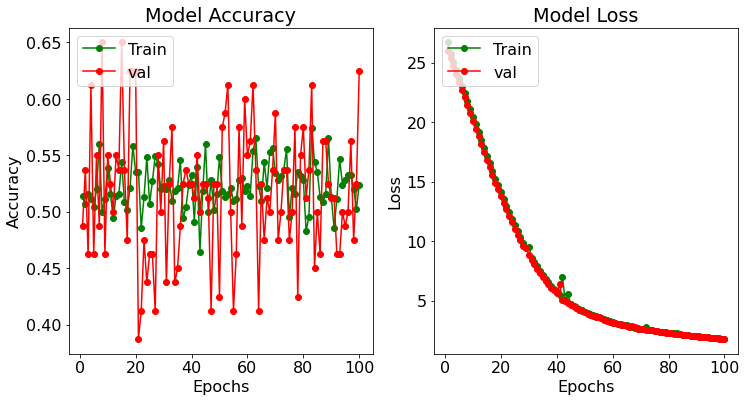

In [190]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_experiment5.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_experiment5.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_experiment5.history["loss"],"go-")
plt.plot(epochs,history_bayes_experiment5.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Predictions with the best Experiment Model

In [191]:
def import_and_predict_bayes_experiment3(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 2))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes_experiment3(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(2)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(2)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(2), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(2), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()
    
    average_estimate = np.array([np.mean(predicted_probabilities[:, i]) for i in range(2)])*100
    prediction_label = label[np.argmax(average_estimate)]
    highest_prediction = average_estimate.max()
    print("Most likely Ocular Condition:", prediction_label, "-", round(highest_prediction,2), "%")
    cert_2p5 = pct_2p5*100
    cert_97p5 = pct_97p5*100
    for i in range(2):
        print(label[i], ": Average estimate = ", round(average_estimate[i],2),
             ": 97.5% ", round(cert_2p5[i], 2), "-", round(cert_97p5[i], 2))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


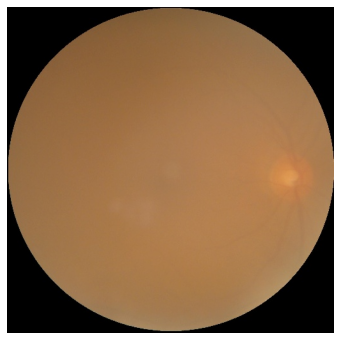

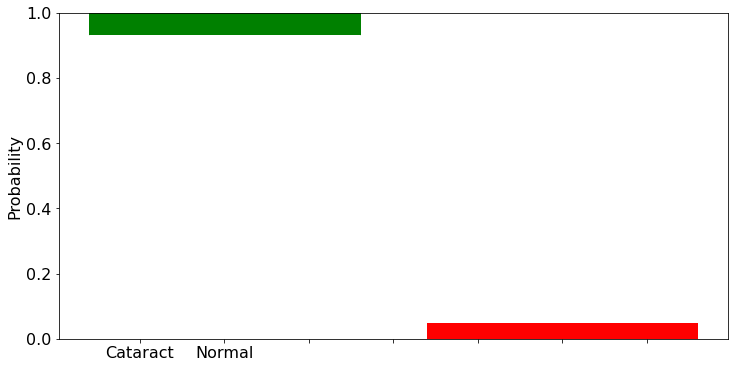

Most likely Ocular Condition: Cataract - 99.08 %
Cataract : Average estimate =  99.08 : 97.5%  95.2 - 99.97
Normal : Average estimate =  0.92 : 97.5%  0.03 - 4.8


In [192]:
import_and_predict_bayes_experiment3(image1_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


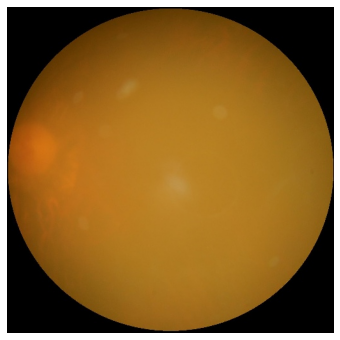

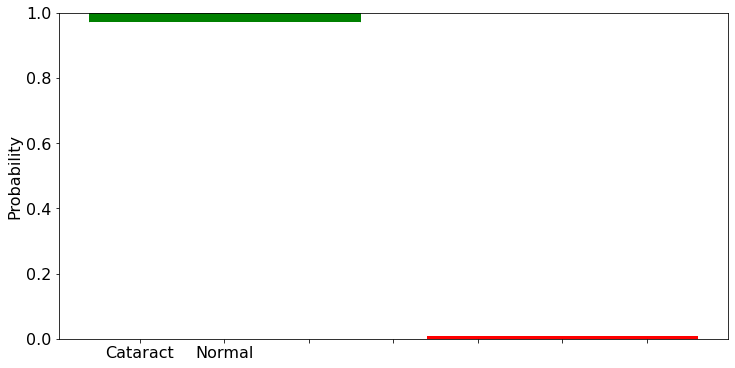

Most likely Ocular Condition: Cataract - 99.82 %
Cataract : Average estimate =  99.82 : 97.5%  99.11 - 99.99
Normal : Average estimate =  0.18 : 97.5%  0.01 - 0.89


In [195]:
import_and_predict_bayes_experiment3(image2_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


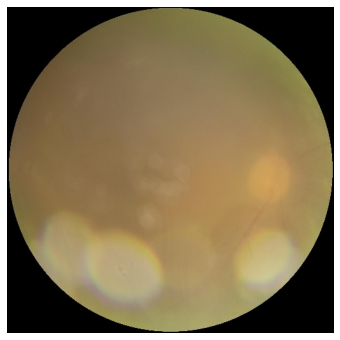

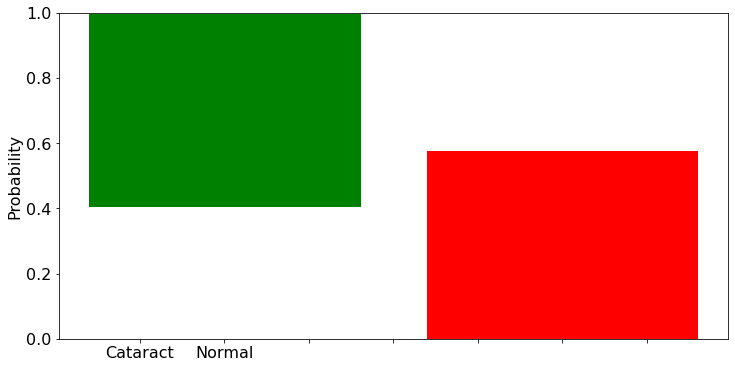

Most likely Ocular Condition: Cataract - 86.42 %
Cataract : Average estimate =  86.42 : 97.5%  42.38 - 99.47
Normal : Average estimate =  13.58 : 97.5%  0.53 - 57.62


In [194]:
import_and_predict_bayes_experiment3(image3_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


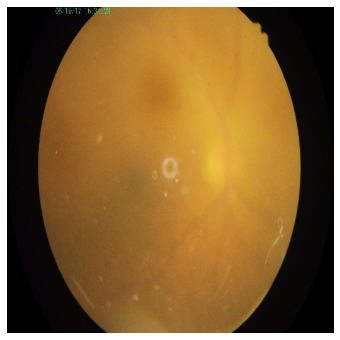

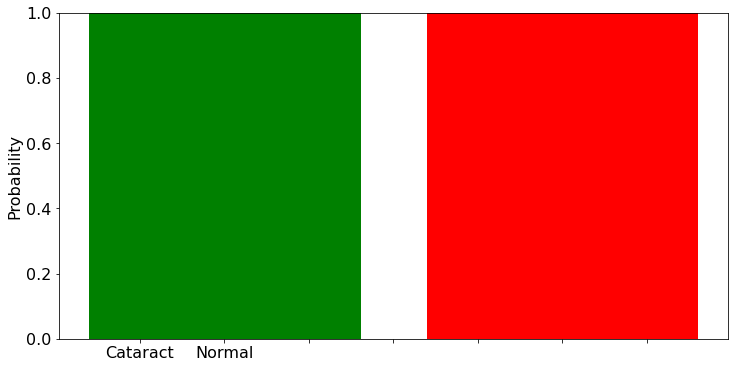

Most likely Ocular Condition: Normal - 52.23 %
Cataract : Average estimate =  47.77 : 97.5%  0.0 - 99.97
Normal : Average estimate =  52.23 : 97.5%  0.03 - 100.0


In [196]:
import_and_predict_bayes_experiment3(image4_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


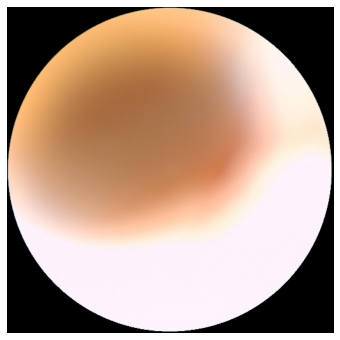

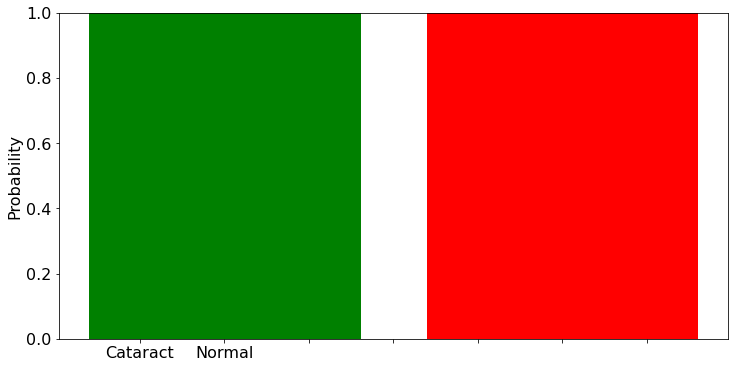

Most likely Ocular Condition: Cataract - 54.64 %
Cataract : Average estimate =  54.64 : 97.5%  0.04 - 99.97
Normal : Average estimate =  45.36 : 97.5%  0.03 - 99.96


In [198]:
import_and_predict_bayes_experiment3(image5_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


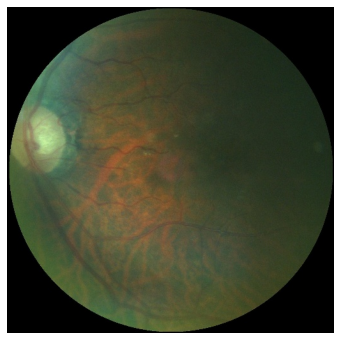

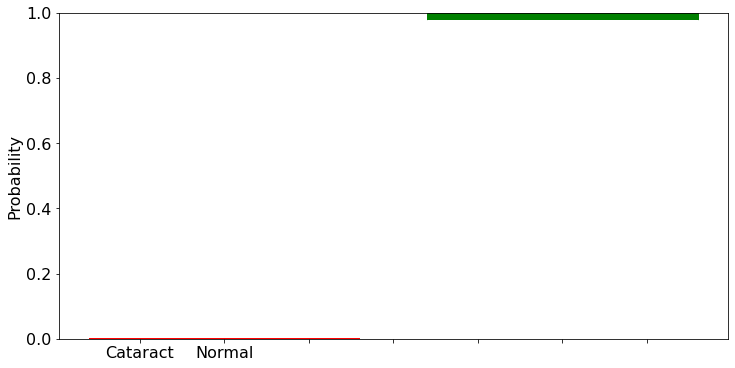

Most likely Ocular Condition: Normal - 99.94 %
Cataract : Average estimate =  0.06 : 97.5%  0.0 - 0.28
Normal : Average estimate =  99.94 : 97.5%  99.72 - 100.0


In [199]:
import_and_predict_bayes_experiment3(image6_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


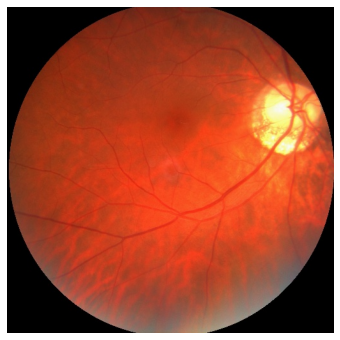

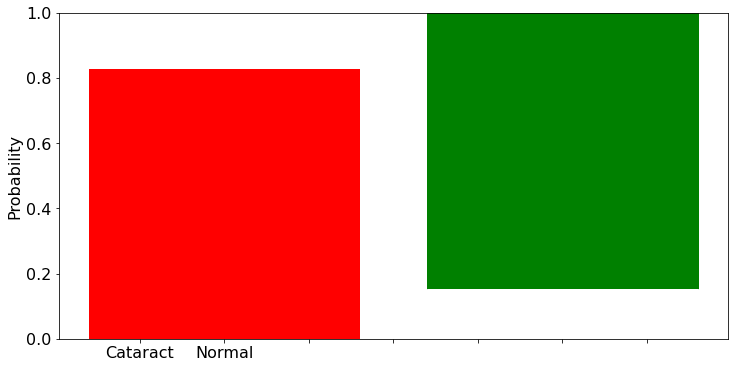

Most likely Ocular Condition: Normal - 93.21 %
Cataract : Average estimate =  6.79 : 97.5%  0.0 - 82.74
Normal : Average estimate =  93.21 : 97.5%  17.26 - 100.0


In [200]:
import_and_predict_bayes_experiment3(image7_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


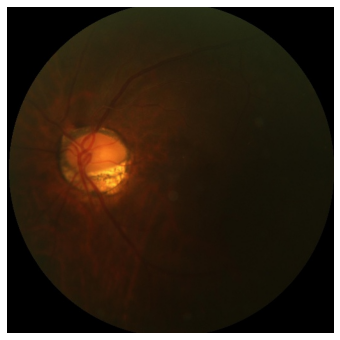

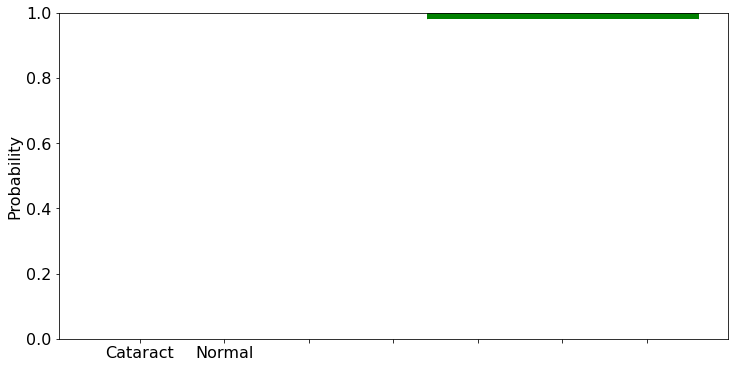

Most likely Ocular Condition: Normal - 99.99 %
Cataract : Average estimate =  0.01 : 97.5%  0.0 - 0.0
Normal : Average estimate =  99.99 : 97.5%  100.0 - 100.0


In [201]:
import_and_predict_bayes_experiment3(image8_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


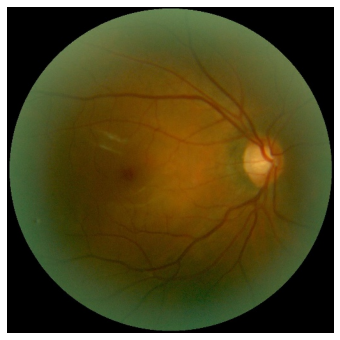

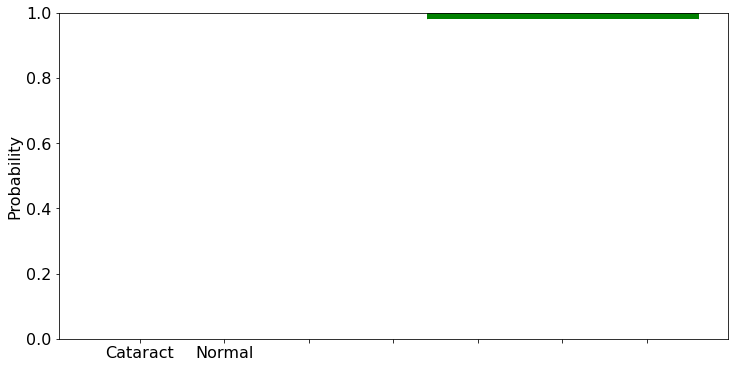

Most likely Ocular Condition: Normal - 100.0 %
Cataract : Average estimate =  0.0 : 97.5%  0.0 - 0.0
Normal : Average estimate =  100.0 : 97.5%  100.0 - 100.0


In [202]:
import_and_predict_bayes_experiment3(image9_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/3997295447.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


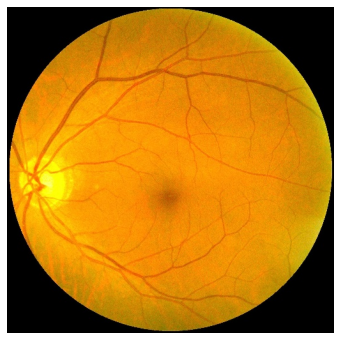

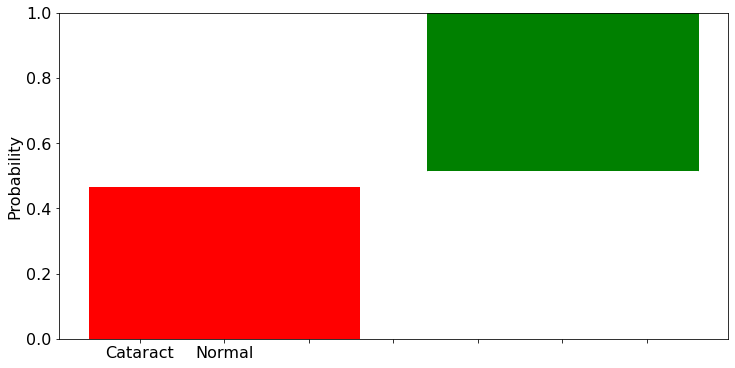

Most likely Ocular Condition: Normal - 91.53 %
Cataract : Average estimate =  8.47 : 97.5%  0.1 - 46.44
Normal : Average estimate =  91.53 : 97.5%  53.56 - 99.9


In [203]:
import_and_predict_bayes_experiment3(image10_dir, label.index('Normal'))

## System Information

In [211]:
import platform
import sys

In [212]:
print("System Information: ")
print("System:",platform.system()) 
print("Architecture:",platform.architecture())  
print("Machine:",platform.machine()) 
print("Processor:",platform.processor()) 
print("Release:",platform.release())
print("Platform:",platform.platform())

System Information: 
System: Windows
Architecture: ('64bit', 'WindowsPE')
Machine: AMD64
Processor: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Release: 10
Platform: Windows-10-10.0.22000-SP0


## Python Information

In [213]:
print(sys.version)

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
